In [10]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
from math import ceil
import torch.optim as optim

In [2]:
landmarks = pd.read_csv('augmented_labels.csv')
n=0
img_name = landmarks.iloc[n, 0]
points = landmarks.iloc[n, 1:]
points = np.asarray(points)
points = points.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(points.shape))
print('First 4 Landmarks: {}'.format(points[:4]))

Image name: 00000001_000.jpg
Landmarks shape: (9, 2)
First 4 Landmarks: [[ 45. 126.]
 [109. 128.]
 [ 69. 165.]
 [ 19.  87.]]


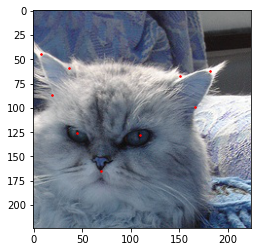

In [3]:
def show_landmarks(image, points):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('cats_augmented', img_name)),
               points)
plt.show()

In [20]:
class CatDataset(Dataset):
    def __init__(self, csv_file, directory):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.directory = directory

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = io.imread(self.directory + self.landmarks_frame.iloc[idx, 0])
        image = image.transpose(2, 0, 1)
        points = landmarks.iloc[idx, 1:]
        points = np.array([points])
        points = points.astype('float').reshape(-1, 2)
        sample = {'image': image, 'points': points}

        return sample

In [21]:
cat_dataset = CatDataset(csv_file='augmented_labels.csv', directory='cats_augmented/')

fig = plt.figure()

for i in range(len(cat_dataset)):
    sample = cat_dataset[i]
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

TypeError: Invalid shape (3, 224, 224) for image data

In [22]:
class DoubleConv(nn.Module):
    expansion = 1

    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 identity_downsample=None, 
                 stride=1):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.identity_downsample = identity_downsample
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x

class TripleConv(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(TripleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, 1)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.identity_downsample = identity_downsample
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, 7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        #Residual layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*block.expansion, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
        
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, 
                                                          out_channels*block.expansion,
                                                          kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(out_channels*block.expansion))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*block.expansion 
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
            
        return nn.Sequential(*layers)

def ResNet34(img_channels=3, num_classes=1000): 
    return ResNet(DoubleConv, [3, 4, 6, 3], img_channels, num_classes)


In [28]:
#Init model
model = ResNet34(img_channels=3, num_classes=18).to(device='cuda')
#dataloader
dataloader = DataLoader(cat_dataset, batch_size=8, shuffle=True, num_workers=0)
#loss and metric
criterion = nn.MSELoss()
def accuracy(out, yb): return(torch.argmax(out, dim=1)==yb).float().mean()
running_loss = 0.0

#hyper parameters
optimizer = optim.Adam(model.parameters(), lr=3e-4)
epochs = 10

model.train()
for epoch in range(epochs):
    for batch_i, data in enumerate(dataloader):
        #get images and labels
        images = data['image']
        key_pts = data['points']
        #flatten points
        key_pts = key_pts.view(key_pts.size(0), -1)
        #convert to float
        images = images.type(torch.cuda.FloatTensor)
        key_pts = key_pts.type(torch.cuda.FloatTensor)

        #forward pass
        output_pts = model(images)
        #loss
        loss = criterion(output_pts, key_pts)
        #zero weight grads, calculate and step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print metric
        running_loss += loss.item()
        if batch_i % 10 == 9:
            print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch+1, batch_i+1, running_loss/10))
            running_loss=0.0

print('Training Finished')
        

Epoch: 1, Batch: 10, Avg. Loss: 12758.77275390625
Epoch: 1, Batch: 20, Avg. Loss: 12293.6353515625
Epoch: 1, Batch: 30, Avg. Loss: 11746.43095703125
Epoch: 1, Batch: 40, Avg. Loss: 11471.2119140625
Epoch: 1, Batch: 50, Avg. Loss: 11303.00771484375
Epoch: 1, Batch: 60, Avg. Loss: 10052.744091796874
Epoch: 1, Batch: 70, Avg. Loss: 8775.182177734376
Epoch: 1, Batch: 80, Avg. Loss: 8706.80146484375
Epoch: 1, Batch: 90, Avg. Loss: 8405.23642578125
Epoch: 1, Batch: 100, Avg. Loss: 7255.277197265625
Epoch: 1, Batch: 110, Avg. Loss: 7814.705419921875
Epoch: 1, Batch: 120, Avg. Loss: 6903.8287109375
Epoch: 1, Batch: 130, Avg. Loss: 5526.33662109375
Epoch: 1, Batch: 140, Avg. Loss: 6122.600390625
Epoch: 1, Batch: 150, Avg. Loss: 5485.372216796875
Epoch: 1, Batch: 160, Avg. Loss: 5435.72568359375
Epoch: 1, Batch: 170, Avg. Loss: 4872.0427734375
Epoch: 1, Batch: 180, Avg. Loss: 4382.713525390625
Epoch: 1, Batch: 190, Avg. Loss: 4117.801843261719
Epoch: 1, Batch: 200, Avg. Loss: 3838.7615966796875
